In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# to check
from scipy.signal import convolve2d
from sklearn.cluster import KMeans
from tqdm import tqdm

Reference for learning about filters- https://homepages.inf.ed.ac.uk/rbf/HIPR2/filtops.htm

In [46]:
# Convolution- flip the kernel both horizontally and vertically
# Then slide- multiply and add

# If the kernel being convolved is symmetrix, we can also do correlation
# Correlation- do not flip, directly multilpy and add
def slow_convolve(image, kernel):
    image_w, image_h = image.shape
    kernel_w, kernel_h = kernel.shape

    counter_x = image_w - kernel_w
    counter_y = image_h - kernel_h 

    if counter_x < 0 or counter_y<0:
        raise ValueError("Kernel must be smaller than Image")
    if len(image.shape)!=2:
        raise TypeError("Image of incorrect shape")
    if len(kernel.shape)!=2:
        raise TypeError("Kernel of incorrect shape")
    
    kernel = np.flipud(np.fliplr(kernel))
    
    output= np.zeros((counter_x+1, counter_y+1))
    for x in range(0, counter_x+1):
        for y  in range (0, counter_y+1):
            patch = np.array(image[x:x+kernel_w, y:y+kernel_h])
            output[x,y] = np.sum(patch * kernel)
    return output

def convolve(image, kernel):
    kH, kW = kernel.shape
    H, W = image.shape
    
    # Pad image
    pad_h = kH // 2
    pad_w = kW // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    
    # Extract sliding windows using stride tricks
    shape = (H, W, kH, kW)
    strides = (padded.strides[0], padded.strides[1], padded.strides[0], padded.strides[1])
    windows = np.lib.stride_tricks.as_strided(padded, shape=shape, strides=strides)

    # Vectorized convolution
    return np.tensordot(windows, kernel, axes=((2,3),(0,1)))


def show_image(img, title="Image"):
    """
    Displays an image using matplotlib.
    
    Parameters:
    -----------
    img : np.ndarray
        The image array (grayscale or color).
    title : str, optional
        Title for the plot.
    """

    # Convert image to numpy array (in case it's not)
    img = np.array(img)

    plt.figure(figsize=(3, 3))
    plt.title(title)
    plt.axis('off')

    # If the image has 3 channels, assume it's color (RGB or BGR)
    if len(img.shape) == 3:
        # If it's BGR (as from OpenCV), convert to RGB
        if img.shape[2] == 3:
            img = img[..., ::-1]  # flip color channels
        plt.imshow(img)
    else:
        # Grayscale image
        plt.imshow(img, cmap='gray')

    plt.show()

def get_rotated_image(img, angle, scale):
    size = int(len(img))
    center = (size//2, size//2)
    M = cv2.getRotationMatrix2D(center, angle, scale)  # angle in degrees, scale=1
    img_rot = cv2.warpAffine(img, M, (size, size), flags=cv2.INTER_LINEAR)
    return img_rot

def get_filter_bank(img, angles, scales):
    img_shape  = img.shape
    filter_bank = np.empty((len(angles)*len(scales), img_shape[0], img_shape[1]))

    filter_count=0
    for scale in scales:
        for angle in angles:
            filter_bank[filter_count]= get_rotated_image(img, angle, scale)
            filter_count+=1

    return filter_bank

def show_filter_bank(filters, r, c, figsize=(12, 8), cmap='gray', titles=None):
    """
    Display a list of filters in a grid of r rows and c columns.

    Parameters:
        filters (list of 2D arrays): The filters to display
        r (int): Number of rows
        c (int): Number of columns
        figsize (tuple): Size of the figure
        cmap (str): Colormap
        titles (list of str): Optional titles for each filter
    """
    n = len(filters)
    plt.figure(figsize=figsize)
    
    for i in range(r*c):
        plt.subplot(r, c, i+1)
        if i < n:
            plt.imshow(filters[i], cmap=cmap)
            plt.axis('off')
            if titles:
                plt.title(titles[i], fontsize=10)
        else:
            # Empty subplot
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()




### Creating filter Banks
#### Oriented DOG

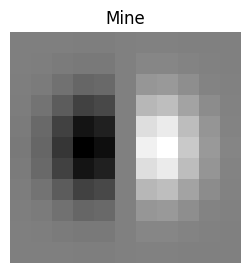

In [3]:
# Gaussian - distribution with a spread sigma contaning (filter_size) number of elements
# 2D gaussian obtained by gaussian_array @ gaussain_arrary.T

# We then take the derivative of the gaussian by convolving it by a sobel kernel- [-1,0,1]
#                                                                                 [-2,0,2]
#                                                                                 [-1,0,1]
# This takes the derivative in x i.e  horizontal direction
# This is later rotated along different orientations with different sigma (acc to scale) to get a filter bank

# Checkinnng filter 1 of derivative of gaussian filters
sobel= np.array([[-1,0,1],[-2,0,2],[-1,0,1]])       #0 degree- horizontal sobel kernel
gaussian = cv2.getGaussianKernel(ksize=13, sigma=1.5)  #1D Gaussian kernel- 5x1 -  ksize is size  and  sigma is standard deviation- spread of the kernel
gaussian_2d = gaussian @ gaussian.T                 #2D Gaussian kernel- 5x5

dog_mine = convolve(gaussian_2d,  sobel)
show_image(dog_mine, "Mine")

gaussian = cv2.getGaussianKernel(ksize=13, sigma=1)  #1D Gaussian kernel- 5x1 -  ksize is size  and  sigma is standard deviation- spread of the kernel
gaussian_2d = gaussian @ gaussian.T                 #2D Gaussian kernel- 5x5


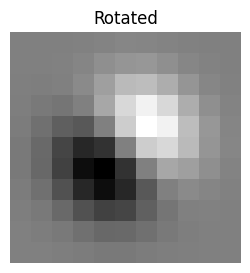

In [4]:
# Checking Rotation
size = int(len(dog_mine))
center = (size//2, size//2)
M = cv2.getRotationMatrix2D(center, 45, 1.0)  # angle in degrees, scale=1
dog_rot_cv = cv2.warpAffine(dog_mine, M, (size, size), flags=cv2.INTER_LINEAR)

show_image(dog_rot_cv, "Rotated")

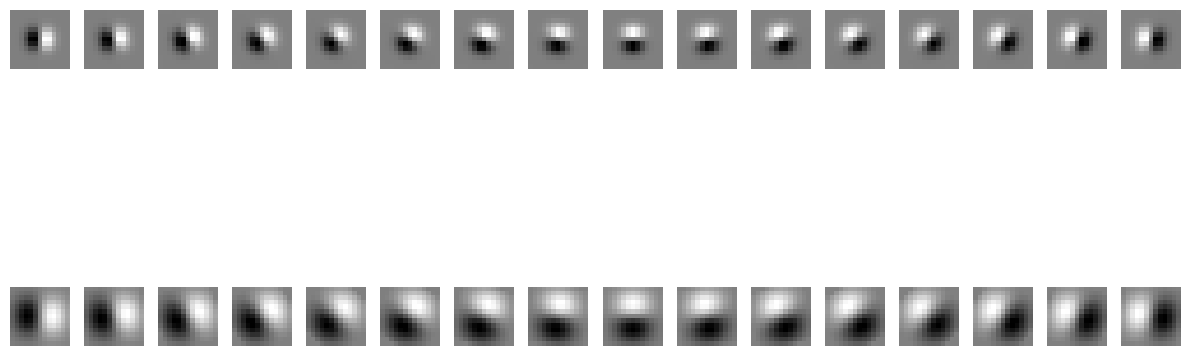

In [5]:
# def createDOGFilter(sigma, filtersize, num_scales,)

def createDOGBank(sigma, filtersize, num_scales, num_orientation):
    angle_dif = 180/num_orientation
    angles  = [i*angle_dif for i in range(num_orientation)]
    scales = [i*1.3 for i in  range(1,num_scales+1)]

    filter_bank = []
    for scale in scales:
        sobel= np.array([[-1,0,1],[-2,0,2],[-1,0,1]])           #0 degree- horizontal sobel kernel
        gaussian = cv2.getGaussianKernel(ksize=filtersize+2, sigma=sigma*scale)   #1D Gaussian kernel- 5x1 -  ksize is size  and  sigma is standard deviation- spread of the kernel
        gaussian_2d = gaussian @ gaussian.T                     #2D Gaussian kernel- 5x5

        dog= convolve(gaussian_2d,  sobel)
        filter_bank.extend(get_filter_bank(dog, angles, np.array([1])))

    return filter_bank


num_scales =1
sigma =1
size =49
dog_bank = createDOGBank(1, 13, 2, 16)
show_filter_bank(dog_bank,2,16)

    
    

#### Leung Malik

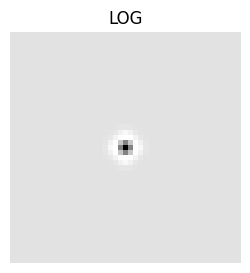

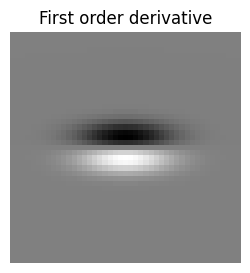

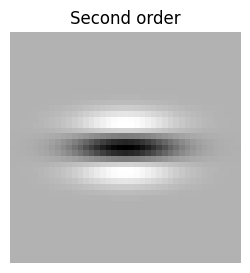

In [6]:
# 48 filters
#     |- 8 Laplacian
#     |- 4 Gaussians
#     |- 18 First order Gaussians (6 orientations, 6 scales)
#     |- 18 Second order Gaussians (6 orientations, 6 scales)
    
# 2 version
#     |- LMS small - σ={1, √2, 2, 2√2}
#     |----- First and second use first 3 (with σ_x= σ, σ_y=3*σ)
#     |----- Gaussians use above σ
#     |----- LOG use σ and 3σ
#     |
#     |-LMS  large - σ={√2, 2, 2√2, 4}

# The laplacian kernel takes second order derivatives in x and y
# The fodg and lodg are sobel derivatives in one direction of the gaussion  


# laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])               # Inverse laplacian?
laplacian = np.array([[0, 0, 1, 0, 0], [0, 1, 2, 1, 0], [1, 2, -16, 2, 1], [0, 1, 2, 1, 0], [0, 0, 1, 0, 0]])
gaussian = cv2.getGaussianKernel(49, 1)
gaussian_2d = gaussian @ gaussian.T

log= convolve(gaussian_2d, laplacian)
show_image(log, "LOG")

sigma = 2
gaussian_x = cv2.getGaussianKernel(49, sigma)
gaussian_y = cv2.getGaussianKernel(49, 3*sigma)
gaussian_2d = gaussian_x @ gaussian_y.T
sobel = np.array([[-2,  -2,  -4,  -2,  -2], [-1,  -1,  -2,  -1,  -1], [0, 0, 0, 0, 0], [1,  1,  2,  1,  1], [2,  2,  4,  2,  2]])

fodg = convolve(gaussian_2d, sobel)
show_image(fodg, "First order derivative")

sodg = convolve(fodg, sobel)
show_image(sodg,  "Second order")


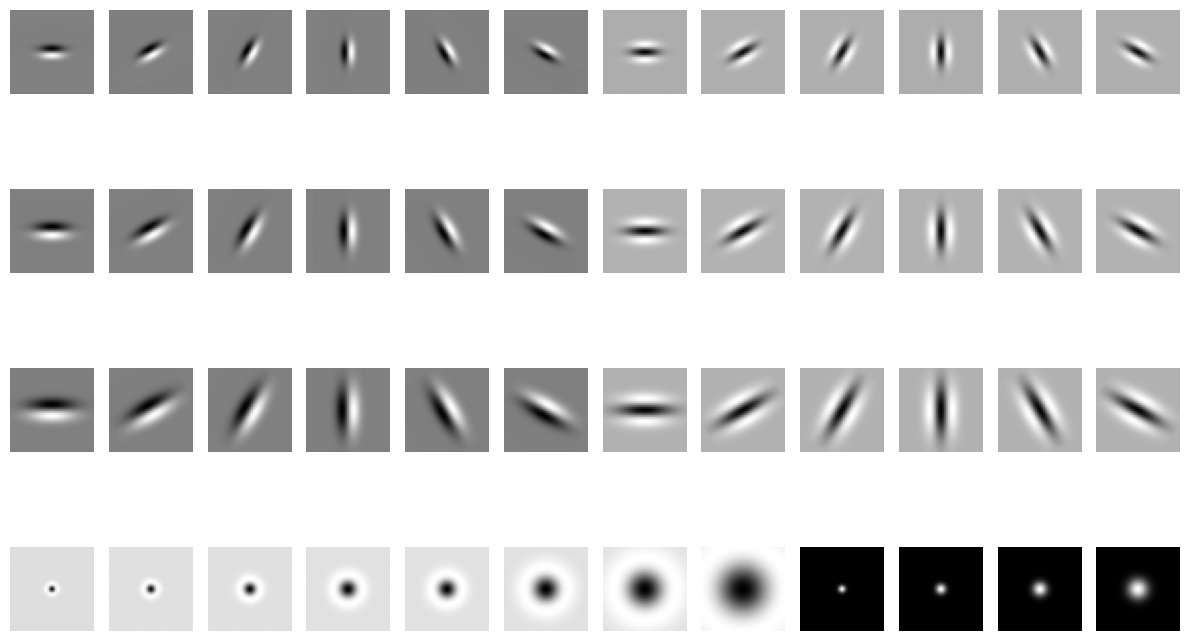

In [7]:
def createLMBank(sigmas, size):

    sobel = np.array([[-2,  -2,  -4,  -2,  -2], [-1,  -1,  -2,  -1,  -1], [0, 0, 0, 0, 0], [1,  1,  2,  1,  1], [2,  2,  4,  2,  2]])
    laplacian = np.array([[0, 0, 1, 0, 0], [0, 1, 2, 1, 0], [1, 2, -16, 2, 1], [0, 1, 2, 1, 0], [0, 0, 1, 0, 0]])

    filter_bank=[]

    # create fodg, sodg
    num_angles=6
    angle_dif = 180/num_angles
    angles = [i*angle_dif for i in range(num_angles)]
    for sigma in sigmas[:3]:
        gaussian_x = cv2.getGaussianKernel(49, sigma)
        gaussian_y = cv2.getGaussianKernel(49, 3*sigma)
        gaussian_2d = gaussian_x @ gaussian_y.T

        fodg = convolve(gaussian_2d, sobel)
        filter_bank.extend(get_filter_bank(fodg, angles, [1]))      # First order derivatives of gaussian
        sodg = convolve(fodg, sobel)
        filter_bank.extend(get_filter_bank(sodg, angles, [1]))      # Second order derivatives of gaussian

    # create laplacian
    sigmas.extend([sigma*3 for sigma in sigmas])
    for sigma  in sigmas:
        gaussian = cv2.getGaussianKernel(49, sigma)
        gaussian_2d = gaussian @ gaussian.T

        log= convolve(gaussian_2d, laplacian)
        filter_bank.append(log)
    
    # create  G
    for sigma in sigmas[:4]:
        gaussian = cv2.getGaussianKernel(size,  sigma)
        gaussian_2d  = gaussian  @ gaussian.T
        filter_bank.append(gaussian_2d)

    return filter_bank

root2 = 2 ** 0.5
sigmas= [1, root2, 2, 2*root2]
lms_bank = createLMBank(sigmas, 49)

sigmas = [root2, 2, 2*root2, 4]
lml_bank = createLMBank(sigmas, 49)
show_filter_bank(lml_bank, 4, 12)

#### Gabor Filters

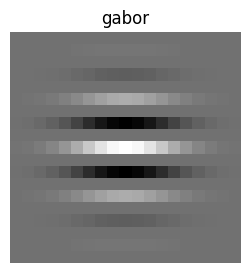

In [8]:
def getGabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(
        abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta))
    )
    xmax = np.ceil(max(1, xmax))
    ymax = max(
        abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta))
    )
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(
        -0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)
    ) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

# def getGabor(sigma, theta, Lambda, psi, gamma):
gabor= getGabor(3, 0, 4, 0, 1)
show_image(gabor, "gabor")

Created 32 Gabor filters


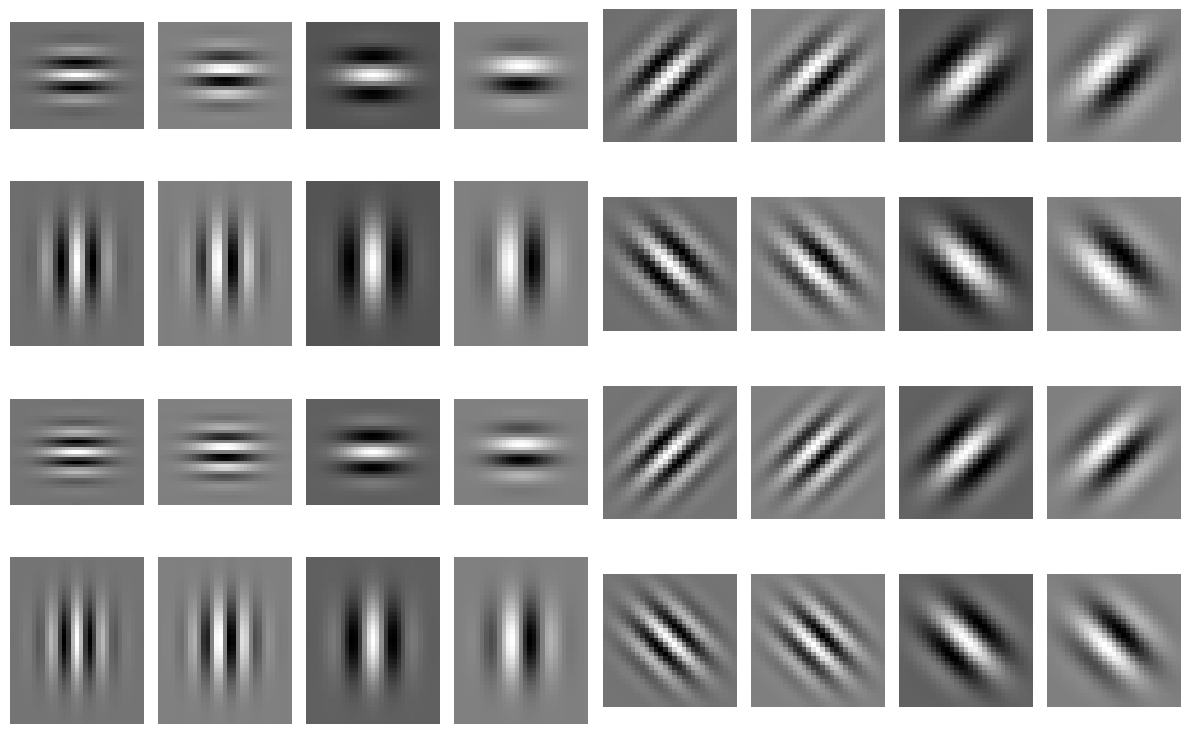

In [9]:
def createGaborBank(sigmas, thetas, Lambdas, psis, gamma):
    """
    Create a Gabor filter bank.
    
    Parameters:
        sigmas : list of float - Gaussian standard deviations
        thetas : list of float - orientations in radians
        Lambdas : list of float - wavelengths
        psis : list of float - phase offsets
        gamma : float - aspect ratio
        
    Returns:
        filters : list of 2D numpy arrays - Gabor filters
    """
    filters = []
    for sigma in sigmas:
        for theta in thetas:
            for Lambda in Lambdas:
                for psi in psis:
                    gb = getGabor(sigma, theta, Lambda, psi, gamma)
                    filters.append(gb)
    return filters


sigmas = [4, 5]                                  # 2 scales
thetas = np.linspace(0, np.pi, 4, endpoint=False)  # 4 orientations
Lambdas = [6, 10]                                # 2 wavelengths
psis = [0, np.pi/2]                              # even and odd
gamma = 0.8                                      # aspect ratio

# Create the reduced filter bank
gabor_bank = createGaborBank(sigmas, thetas, Lambdas, psis, gamma)
print(f"Created {len(gabor_bank)} Gabor filters")  # Should print 32

show_filter_bank(gabor_bank, 4, 8)



### Making Maps


In [10]:
def create_map(num_clusters, image_features, im_shape):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    if image_features.ndim ==2:
        num_filters=1
    else:                                                       # for filterbank
        num_filters = len(image_features[0][0])
                        
    feature_map_vector = image_features.reshape(-1, num_filters)
    print(feature_map_vector.shape)
    feature_labels = kmeans.fit_predict(feature_map_vector)

    feature_map = feature_labels.reshape(im_shape)
    return feature_map

#### Texton Map

100%|██████████| 160/160 [03:35<00:00,  1.35s/it]


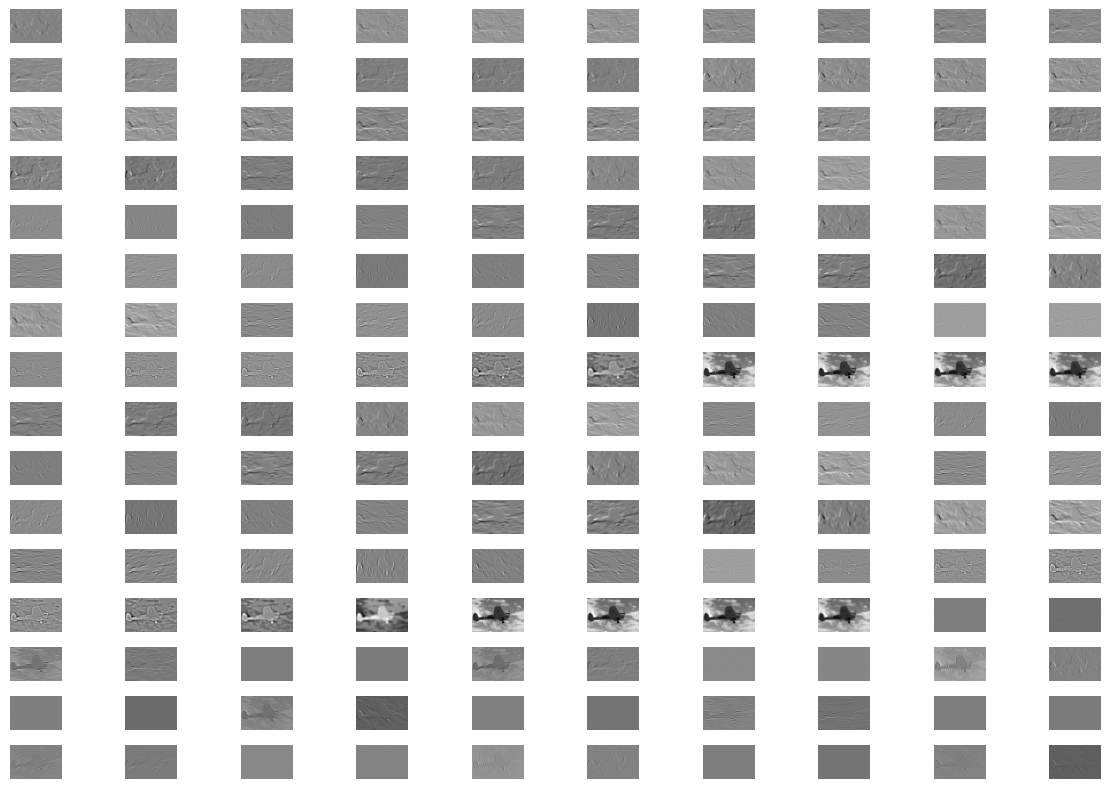

In [ ]:
# Pad image and covolve such that each image in center for kernel

def convolve_with_filter_bank(filter_bank, img):
    (w,h)=img.shape
    img= cv2.copyMakeBorder(img, pad_by, pad_by, pad_by, pad_by, cv2.BORDER_REPLICATE)
    (new_w,new_h)=img.shape
    w_start = pad_by
    w_end = w_start+w
    h_start= pad_by
    h_end = h_start+h
    
    filter_bank_size = len(filter_bank)
    texton_vectors = np.empty((filter_bank_size,w,h))

    for filter_i, filter in enumerate(tqdm(filter_bank)):
        filter_w, filter_h = filter.shape

        extra_w = (filter_w-1)//2
        extra_h = (filter_h-1)//2
        
        if filter_w%2==0 and filter_w%h==0:
            patch=img[w_start-extra_w:w_end+extra_w+1, h_start-extra_h:h_end+extra_h+1]
        elif filter_w%2!=0 and filter_w%h==0:
            patch=img[w_start-extra_w:w_end+extra_w, h_start-extra_h:h_end+extra_h+1]
        elif filter_w%2==0 and filter_w%h!=0:
            patch=img[w_start-extra_w:w_end+extra_w+1, h_start-extra_h:h_end+extra_h]
        else:
            patch=img[w_start-extra_w:w_end+extra_w, h_start-extra_h:h_end+extra_h]
        
        filter_output = convolve(patch, filter)
        texton_vectors[filter_i] = filter_output

    return texton_vectors

pad_by = 24
filter_bank=dog_bank + lms_bank +  lml_bank + gabor_bank

img = cv2.imread(r"F:\CV\RBE549\Nehal_hw0\Phase1\BSDS500\Images\1.jpg", cv2.IMREAD_GRAYSCALE)

texton_vectors_per_image = convolve_with_filter_bank(filter_bank, img)
show_filter_bank(texton_vectors_per_image, 16, 10)



(154401, 160)


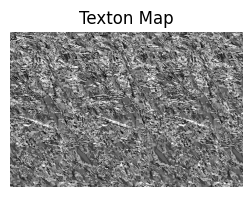

In [12]:
texton_clusters = 64
texton_map = create_map(texton_clusters, texton_vectors_per_image.T, img.shape)

show_image(texton_map, "Texton Map")

#### Brighness Map

(154401, 1)


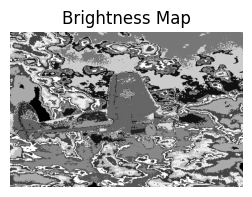

In [45]:
brightness_clusters = 16
brightness_map = create_map(brightness_clusters, img, img.shape)

show_image(brightness_map, "Brightness Map")

#### Color Map

(154401, 3)


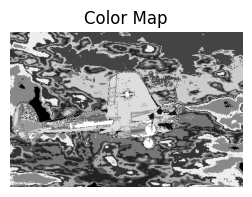

In [14]:
color_clusters = 16
img = cv2.imread(r"F:\CV\RBE549\Nehal_hw0\Phase1\BSDS500\Images\1.jpg", cv2.IMREAD_COLOR_BGR)
color_map = create_map(color_clusters, img, img.shape[:2])

show_image(color_map, "Color Map")

### Gradients
#### Half Disk Masks

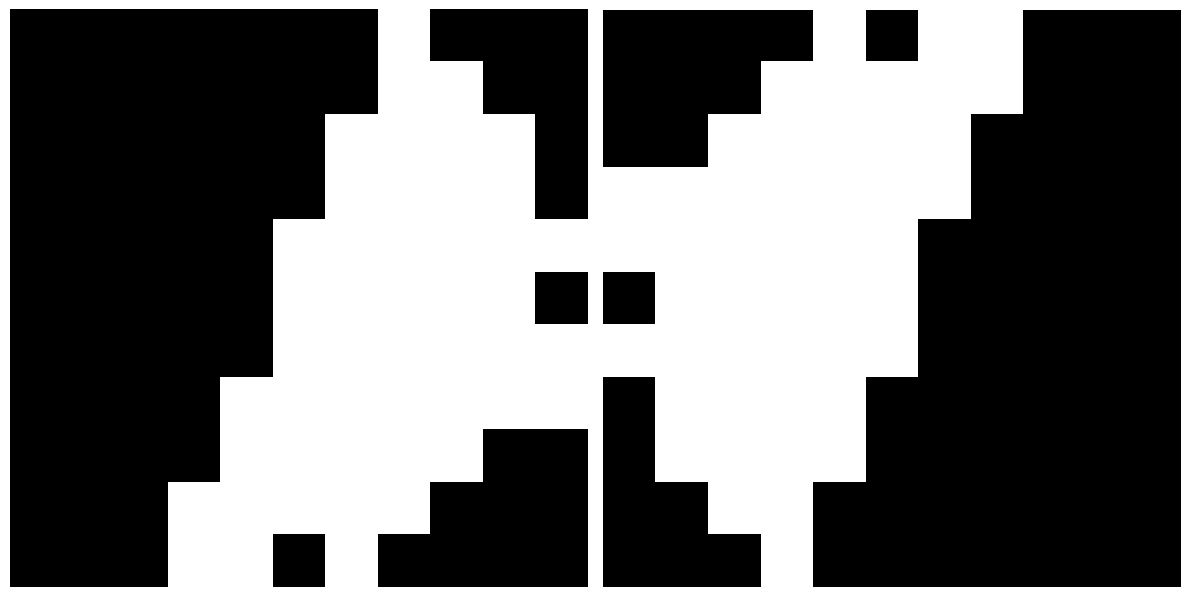

In [16]:
def create_half_disk(size):
    img = np.zeros((size, size), dtype=np.uint8)

    # Semi-circle parameters
    center = (size // 2, size // 2)     
    radius = size // 2                  # diameter = height => radius = height/2
    start_angle = 0                     # start angle of the arc in degrees
    end_angle = 180                     # end angle of the arc in degrees
    color = 255                         # white
    thickness = -1                      # fill the semicircle

    # Draw semicircle
    cv2.ellipse(img, center, (radius, radius), 0, start_angle, end_angle, color, thickness)

    return img

def get_half_disks():
    sizes = [11, 15, 23]
    masks = []
    for size in sizes:
        masks.append(create_half_disk(size))

    return masks

def get_half_disk_masks(num_orientations):
    angle_dif = 360/num_orientations
    angles = [i*angle_dif for i in range(num_orientations)]

    disks = get_half_disks()
    rotated_disks = []
    for disk in disks:
        rotated_disks.extend(get_filter_bank(disk, angles, [1]))

    for i in range(len(rotated_disks)):
        rotated_disks[i]= np.where(rotated_disks[i] >= 128, 255, 0).astype(np.uint8)
    return rotated_disks

def get_pairs_hdm(hdm, scales,  num_orienttions):
    pair_list = []
    pairs = num_orientations//2
    for j in range(scales):
        for i in range(pairs):
            pair_list.append([hdm[j*num_orientations + i], hdm[j*num_orientations + pairs + i]])

    return  pair_list

scales =3
num_orientations  = 16
hdm=get_half_disk_masks(num_orientations)  
# show_filter_bank(hdm, 3, 8)

pairs_hdm=get_pairs_hdm(hdm, 3, 16)
show_filter_bank(pairs_hdm[3], 1, 2)

#### χ2 distance

In [57]:
def calculate_chi_distance(filter_bank, map, pad_by, num_clusters):
    img_h, img_w = map.shape
    map_updated= cv2.copyMakeBorder(map, pad_by, pad_by, pad_by, pad_by, cv2.BORDER_REPLICATE)
    h, w = map_updated.shape
    maps_by_cluster = (map_updated[None, :, :] == np.arange(num_clusters)[:, None, None]).astype(np.float32)

    w_start = pad_by
    w_end = w_start+img_w
    h_start= pad_by
    h_end = h_start+img_h
    
    filter_bank_size = len(filter_bank)

    chi2_maps = np.empty((img_h, img_w, filter_bank_size))
    

    for filter_i, filter in enumerate(tqdm(filter_bank)):
        filter_g, filter_h = filter
        filter_g_w, filter_g_h = filter_g.shape

        extra_w = (filter_g_w-1)//2
        extra_h = (filter_g_h-1)//2
        
        # if filter_g_w%2==0 and filter_g_h%h==0:
        #     patch=maps_by_cluster[:, h_start-extra_h:h_end+extra_h+1,w_start-extra_w:w_end+extra_w+1]
        # elif filter_g_w%2!=0 and filter_g_h%h==0:
        #     patch=maps_by_cluster[:, h_start-extra_h:h_end+extra_h+1,w_start-extra_w:w_end+extra_w]
        # elif filter_g_w%2==0 and filter_g_h%h!=0:
        #     patch=maps_by_cluster[:, h_start-extra_h:h_end+extra_h,w_start-extra_w:w_end+extra_w+1]
        # else:
        #     patch=maps_by_cluster[:, h_start-extra_h:h_end+extra_h,w_start-extra_w:w_end+extra_w]
        
        patch = maps_by_cluster[:, h_start:h_end,w_start:w_end]
    
        convolved_g = np.empty((texton_clusters, img_h, img_w))
        convolved_h = np.empty((texton_clusters, img_h, img_w))
        # print("filter, patch,  convolved- ", filter_g.shape, patch.shape, convolved_g.shape)
        for i in tqdm(range(num_clusters)):
            convolved_g[i] = convolve(patch[i], filter_g)
            convolved_h[i] = convolve(patch[i], filter_h)

        mask = (convolved_g + convolved_h) > 0
        chi2_map = 0.5 * np.sum(
            ((convolved_g - convolved_h) ** 2 / (convolved_g + convolved_h + 1e-4)) * mask,
            axis=0
        )
        chi2_maps[:,:,filter_i] = chi2_map

    return chi2_maps

In [53]:
h,w = texton_map.shape
chi2_map_texton = calculate_chi_distance(pairs_hdm, texton_map, h//2, texton_clusters)
print(chi2_map_texton.shape)    

100%|██████████| 24/24 [06:40<00:00, 16.70s/it]

(321, 481, 24)


In [58]:
# Calculate chi distance for brightness
h,w = brightness_map.shape
chi2_map_brightness = calculate_chi_distance(pairs_hdm[:3], brightness_map, h//2, brightness_clusters)
print(chi2_map_brightness.shape)



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

(321, 481, 3)


In [59]:
# Calculate chi distance for color
h,w = color_map.shape
chi2_map_color = calculate_chi_distance(pairs_hdm[:3], color_map, h//2, color_clusters)
print(chi2_map_color.shape)

100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

(321, 481, 3)


###  Putting it all together

In [ ]:
sobel_baseline = cv2.imread(r"F:\CV\RBE549\Nehal_hw0\Phase1\BSDS500\SobelBaseline\1.png", cv2.IMREAD_GRAYSCALE)
canny_baseline = cv2.imread(r"F:\CV\RBE549\Nehal_hw0\Phase1\BSDS500\CannyBaseline\1.png", cv2.IMREAD_GRAYSCALE)

Tg = np.mean(chi2_map_texton, axis = 2)
Bg = np.mean(chi2_map_brightness, axis = 2)
Cg = np.mean(chi2_map_color, axis = 2)


w1=w2=0.5
pb_edges = (Tg+Bg+Cg) * (w1*canny_baseline + w2*sobel_baseline)
only_pb = Tg+Bg+Cg 
print(pb_edges.shape)


(321, 481)


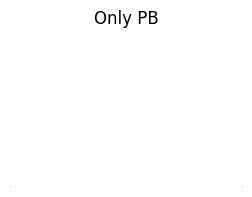

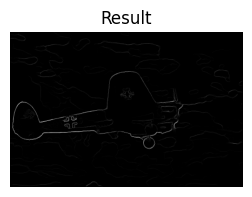

In [67]:
show_image(only_pb, "Only PB")
show_image(pb_edges, "Result")

In [68]:
print(only_pb.mean, only_pb.min, only_pb.max)

<built-in method mean of numpy.ndarray object at 0x000001F604FBBDB0> <built-in method min of numpy.ndarray object at 0x000001F604FBBDB0> <built-in method max of numpy.ndarray object at 0x000001F604FBBDB0>
